

# US FOMC Statements Interest Rate Forecaster




In [4]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import SnowballStemmer
from xgboost import XGBClassifier, plot_importance
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Import Data and Data Modification
Interest rate and FOMC statements.

In [56]:
## Interest Rates

df_int= pd.read_csv('FEDFUNDS.csv')
df_int['DATE'] = pd.to_datetime(df_int['DATE'])
df_int.columns = ['date','rate']

In [57]:
## FOMC statements

df_texts = pd.read_csv("FOMC statements.csv")
df_texts = df_texts[['release_date',"text"]]
df_texts.columns = ['date','text']
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts['date'] = df_texts['date'] + pd.offsets.MonthBegin(1)
df_texts = df_texts.groupby('date')['text'].agg(lambda x: ' '.join(x)).reset_index()

In [58]:
df_texts

,date,text
0,1999-06-01,The Federal Reserve released the following sta...
1,1999-07-01,The Federal Open Market Committee today voted ...
2,1999-09-01,With financial markets functioning more normal...
3,1999-11-01,The Federal Open Market Committee decided toda...
4,1999-12-01,Although cost pressures appear generally conta...
...,...,...
198,2023-08-01,Recent indicators suggest that economic activi...
199,2023-10-01,Recent indicators suggest that economic activi...
200,2023-12-01,Recent indicators suggest that economic activi...
201,2024-01-01,Recent indicators suggest that growth of econo...


In [59]:
## Convert to monthly data, combine to single dataframe

df_int.set_index(['date'], inplace=True)
df_texts.set_index(['date'], inplace=True)
df_texts.sort_index(inplace=True)
df_texts.index = df_texts.index + pd.offsets.MonthBegin(1)
df_int.index = df_int.index + pd.offsets.MonthBegin(1)
df_complete = df_texts.merge(df_int,left_index=True, right_index=True)

In [60]:
## Calculate 6 month change

df_temp = df_complete.copy()
df_temp['change_6'] = df_complete['rate'].diff(6)

In [61]:
## Shift the interest rate change records up
df_temp['change_6'] = df_temp['change_6'].shift(-6)

### Target Creation
Target value will not be the exact interest rate, it will be the following 6 month sentiment (hawkish, dovish, neutral).  Since the actual interest rate varies day to day by slight amounts, a threshold will be set that the 6 month change must exceed for it to be considered a change.  

In [64]:
y = df_temp[['change_6']]

# Drop the NAN columns
text = df_temp[:-6]
y = y[:-6]

y_threshold = 0.25

def map_to_class(value):
    if value > y_threshold:
        return 1
    elif -y_threshold <= value <= y_threshold:
        return 0
    else:
        return -1
    
y['change_6'] = y['change_6'].map(map_to_class)

In [65]:
text.shape

(195, 3)

In [66]:
y.shape

(195, 1)

In [67]:
## Check for class balance

y['change_6'].value_counts()

change_6
 0    83
 1    64
-1    48
Name: count, dtype: int64

In [68]:
y = y.fillna(1)

### Modelling
This will include preprocessing, model fitting, model accuracy testing.
1. Lower case
2. Stemming
3. TFIDF vectorizer
4. Modelling using XGBoost

Here we use train_test_split function in sklearn to split the dataset into training set and test set. We examine the robustness of the model by choosing different combinations of training set and test set. 

In [69]:
## Lower case

text['text'] = [i.lower() for i in text['text']]

## Stemming

snow = SnowballStemmer('english',)
text['text'] = [snow.stem(i) for i in text['text']]

In [70]:
## Instantiate a TFIDF vectorizer

vect = TfidfVectorizer(
                        stop_words='english', 
                       max_features = 500, 
                       ngram_range=(1, 3),
                       token_pattern=r"\b[a-zA-Z]{3,}\b")

X_text = vect.fit_transform(text['text'])

# Create a DataFrame to examine
text_filtered = pd.DataFrame(X_text.toarray(), columns=vect.get_feature_names_out ())
text_tfidf = text_filtered.copy() # create backup of TFIDF text for later use
text_filtered.head()

,accommodation,accommodative,accommodative stance,accommodative stance monetary,account,account wide,account wide range,action,actions,activity,...,underlying,unemployment,unemployment rate,utilization,view,warrant,wide,wide range,wide range information,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155147,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184420,0.000000,0.099893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262881,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153291,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140392,0.158319,0.076045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111892


In [71]:
## XGBoost model fitting and testing

xgb_model = XGBClassifier(objective='multi:softmax',
                          max_depth=3,
                          num_classes=3)

train_scores = []
test_scores = []

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y["change_6"] = le.fit_transform(y["change_6"])

for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(text_tfidf, y,test_size=0.3)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    test_score = round(xgb_model.score(X_test, y_test),2)
    train_score = round(xgb_model.score(X_train, y_train),2)
    # print(f'{xgb_model.get_params}')
    print(f'Run {x}... train: {train_score}, test: {test_score}')
    train_scores.append(train_score)
    test_scores.append(test_score)

print(f'Train average: {np.mean(train_scores)}')
print(f'Test average: {np.mean(test_scores)}')

Run 0... train: 1.0, test: 0.86
Run 1... train: 1.0, test: 0.83
Run 2... train: 1.0, test: 0.86
Run 3... train: 1.0, test: 0.88
Run 4... train: 1.0, test: 0.76
Run 5... train: 1.0, test: 0.92
Run 6... train: 1.0, test: 0.83
Run 7... train: 1.0, test: 0.76
Run 8... train: 1.0, test: 0.85
Run 9... train: 1.0, test: 0.81
Train average: 1.0
Test average: 0.836


### Feature Importance
We calculated feature importance of different words and found that words such as "levels", "economic growth", "rise" are contributing the most to the prediction

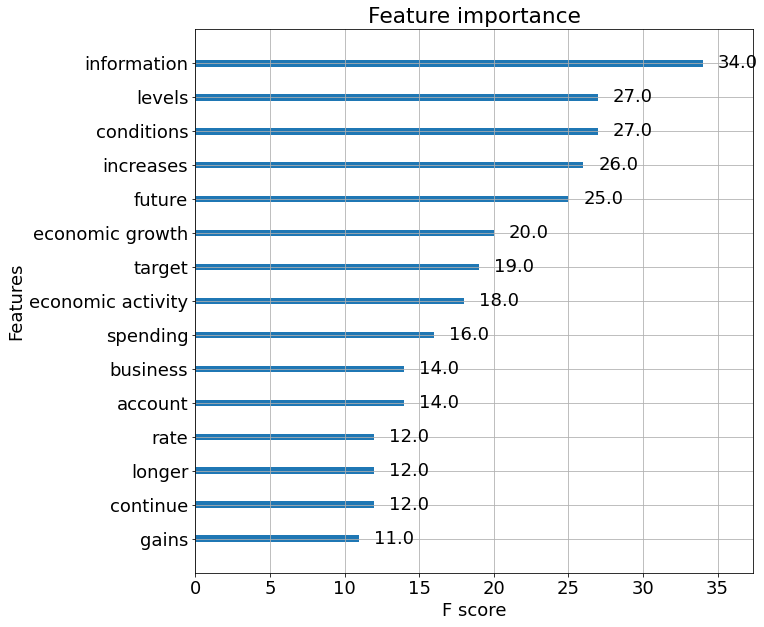

In [72]:
## Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
ax.yaxis.label.set_size(18)
plot_importance(xgb_model, max_num_features = 15, ax=ax);

### Ploting Actual VS Predicted
Plotting the predicted rate changes and actual rates changes together,it is clear that the model correctly predicted the most of data points.

In [73]:
## Defeine predictions vs actual

y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text_tfidf)
y_pred['change_6_pred'] = y_pred['change_6_pred'] -2.5
y_pred['change_6'] = y_pred['change_6']

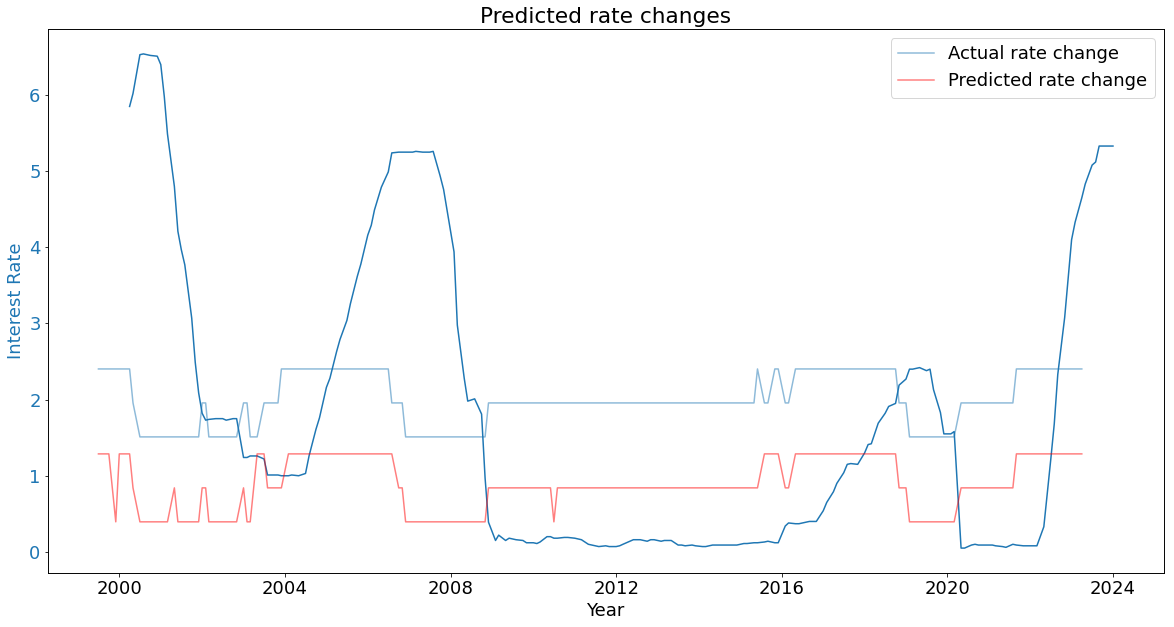

In [74]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color) 
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label
         ='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

### Partial Data Testing
By removing long periods of recent data, we can see how this affects the prediction accuracy of recent periods. When using only data before 2008 for training and data after 2008 for testing, we obtained the prediction score significantly lower than the previous one. It wasn't able to correctly identify the past unprecedented low and neutral interest rate environment after 2010.

In [75]:
## XGBoost model fitting and testing

def xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test):
    xgb_model = XGBClassifier(objective='multi:softmax',
                              max_depth=3,
                              num_classes=3)
    
    # Show performance scores for the partial set
    train_scores = []
    test_scores = []
    
    for x in range(5):
        X_train, X_test, y_train, y_test = train_test_split(text_partial_train, y_partial_train , test_size=0.3)

        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        test_score = round(xgb_model.score(X_test, y_test),2)
        train_score = round(xgb_model.score(X_train, y_train),2)

        train_scores.append(train_score)
        test_scores.append(test_score)
    print(f'Train partial set average (pre-split): {np.mean(train_scores)}')
    print(f'Test partial set average (pre-split): {np.mean(test_scores)}')

    # Show performance scores for the full set
    full_score = round(xgb_model.score(text_partial_test, y_partial_test),2)
    print(f'Post-split date range score: {full_score}')
    
    # Plot predictions
    y_pred = y_partial_test.copy()
    y_pred['change_6_pred'] = xgb_model.predict(text_partial_test)
    y_pred['change_6_pred'] = y_pred['change_6_pred'] - 2.5
    y_pred['change_6'] = y_pred['change_6']
    
    fig, ax1 = plt.subplots(figsize=(20, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Interest Rate', color=color)
    ax1.plot( df_temp['rate'][6:], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    ax2.set_ylim(bottom=-4, top=12)
    ax2.get_yaxis().set_visible(False)

    color = 'tab:blue'
    ax2.set_ylabel('Interest Rate Change', color=color)  
    ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.legend()
    plt.title('Predicted rate changes - Partial Dataset Training')
    plt.show()
    
    return None

In [76]:
## Split data based on date
y_partial_train = y.loc[:'2008-01-01']
text_partial_train = text_tfidf.loc[:y_partial_train.shape[0]-1]
y_partial_test = y.loc['2008-02-01':]
text_partial_test = text_tfidf.loc[:y_partial_test.shape[0]-1]

Train partial set average (pre-split): 1.0
Test partial set average (pre-split): 0.636
Post-split date range score: 0.23


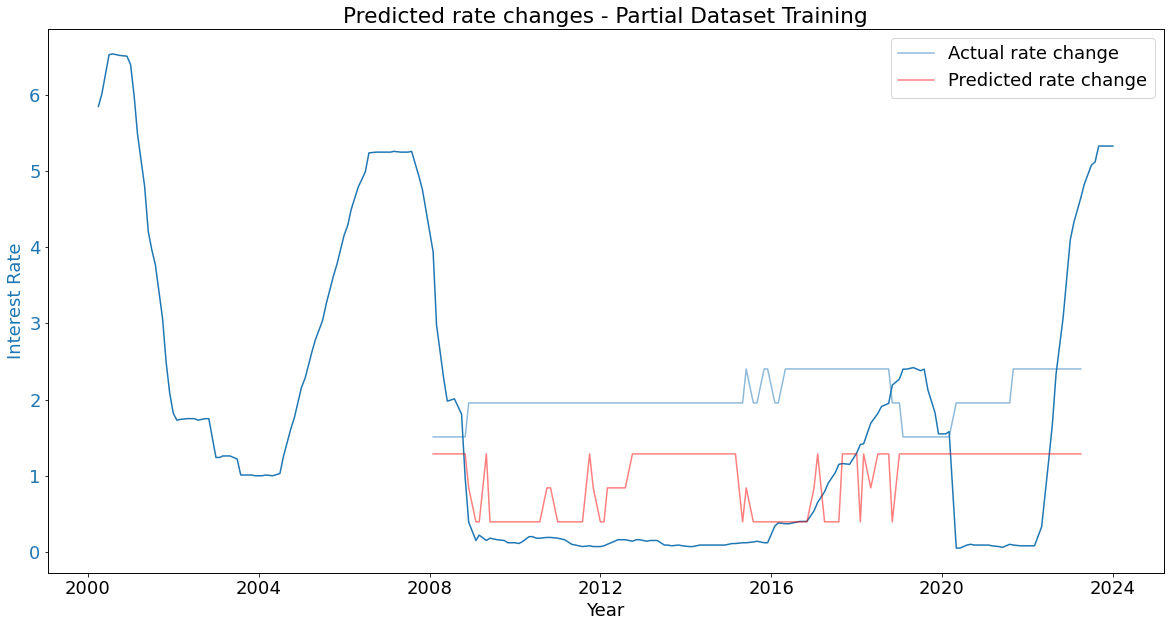

In [77]:
# xgb_function(text_partial, y_partial, text, y)
xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test)

### Backtesting on the whole dataset

In reality, the tool would be used to estimate a rolling prediction every month.  Accuracy of long-term projections wouldn't be used and wouldn't be practical.  One would also want to train the model on as much relevant data as possible.  As such, the best accuracy score would be scoring it only on how well it predicts the immediate future over time. Here, we calculated the prediction with data in January and in June. <br><br>
The final test will be testing a sample of predictions from a large range of time.


In [78]:
years = [i for i in range(2003,2023)]
test_results = [] 


for x in years:
    y_partial = y.loc[:str(x-1)+'-01-01']
    text_partial = text_tfidf.loc[:y_partial.shape[0]-1]
    
    # Train test split - don't train the model on all data, reduce overfit
    X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)
    
    # Train model
    xgb_model.fit(X_train, y_train)
    
    # Make prediction for next period
    pred = xgb_model.predict(text_tfidf.loc[y_partial.shape[0]:y_partial.shape[0]])
    actual = y[:y_partial.shape[0]].tail(1).iloc[0,0]

    if pred == actual:
        test_results.append(1)
    else:
        test_results.append(0)
        
    y_partial = y.loc[:str(x-1)+'-06-30']
    text_partial = text_tfidf.loc[:y_partial.shape[0]-1]
    
    # Train test split - don't train the model on all data, reduce overfit
    X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)
    
    # Train model
    xgb_model.fit(X_train, y_train)
    
    # Make prediction for next period
    pred = xgb_model.predict(text_tfidf.loc[y_partial.shape[0]:y_partial.shape[0]])
    actual = y[:y_partial.shape[0]].tail(1).iloc[0,0]

    if pred == actual:
        test_results.append(1)
    else:
        test_results.append(0)

In [79]:
correct = sum(num == 1 for num in test_results)
incorrect = sum(num == 0 for num in test_results)
score = (correct / (correct+incorrect))
print('Score from a sample range: ' + str(round(score,2)))

Score from a sample range: 0.78


### Conclusion
When the model is trained only on past environments, it performs very poorly, around 30% at best with a split at the year 2008.  This proves that it does rely on the unique features of every interest rate environment to forecast accurately.  Using a rolling sample, with each sample given the most recent information (-6 months maximum), the performance is back up to about 75%.

If the model is not trained on a specific environment's statements, the statements may hold features that are significantly different from the past, and a model not trained on the new environment may have no predictive value. A model trained on the new current environment may be overfitting to the environment so far, and have no ability to anticipate a change.

There is no easy solution to forecasting US interest rates. NLP on FOMC statements may be a valuable tool if combined with several other tools. It should only be considered one flag. Even if a current market environment is unique, FOMC statements may still contain feature similarities from other past market shocks that forecasted rate change (Fed over-confidence, fed warnings about risk, etc).